<a href="https://colab.research.google.com/github/AnirudhDeshpande/My-Learning/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Working with Images and Logistic Regression
We use the knowledge of PyTorch and Linear Regression to solve a very different kind of problem: Image Classification.
We use the MNIST Handwritten Digits Database as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents.

torchvision contains some utilities for working with image data. It also provides helper classes to download and import popular datasets like MNIST automatically.

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
#Downloading training dataset
dataset=MNIST(root='data/',download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



When this statement is executed for the first time, it downloads the data to the data/ directory next to the notebook and creates a PyTorch dataset. 

In [3]:
#size of the dataset
len(dataset)

60000

The dataset has 60000 images that we'll use to train the model. There is also an additional test set of 10000 images used for evaluating models. We create the test dataset using the MNIST class by passing train=False to the constructor.

In [4]:
test_dataset=MNIST(root='data/',train=False)
len(test_dataset)

10000

In [5]:
#Sample element from the training dataset
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F2B3FC689D0>, 5)

It's a pair consisting of a 28px by 28px image and a label. The image is an object of the class PIL.Image.Image, which is a part of the Python imaging library **Pillow**.

We can view the image using **matplotlib**, the de-facto plotting and graphing library for data science in Python. 

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

The statement matplotlib inline indicates that we want to plot the graphs within the notebook. Without this line, the notebook will show the image in a popup. Statements starting with % are called magic commands and are used to configure the behaviour of notebook itself.

Label: 5


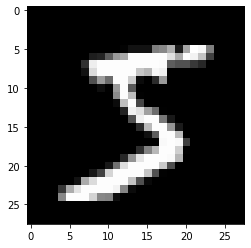

In [7]:
#Lets look at a couple of images from the dataset
image,label=dataset[0]
plt.imshow(image, cmap='gray')
print('Label:',label)

Label: 3


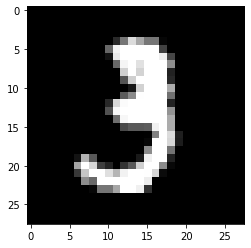

In [8]:
image,label=dataset[10]
plt.imshow(image,cmap='gray')
print('Label:',label)

PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [9]:
import torchvision.transforms as transforms

PyTorch datasets allows us to specify one or more transformations functions that are applied to the images as they are loaded. The **torchvision.transforms** module contains many such predefined functions. We'll use the ToTensor transform to convert images into PyTorch tensors.

In [10]:
dataset=MNIST(root='data/',train=True, transform=transforms.ToTensor())

In [11]:
img_tensor,label=dataset[0]
print(img_tensor.shape,label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green and blue (RGB)

In [17]:
#Sample values inside the tensor
print(img_tensor[0,10:15,10:15])

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])


In [18]:
print(torch.max(img_tensor),torch.min(img_tensor))

tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white, and the values in between different shades of gray.

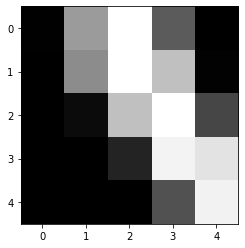

In [20]:
#We can also plot the tensor as an image using plt.imshow
plt.imshow(img_tensor[0,10:15,10:15],cmap='gray')

Note that we need to pass just the 28x28 matxix to plt.imshow, without a channel dimension. We also pass a color map(cmap=gray) to indicate that we want to see a grayscale image.

### Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. Training set- used to evaluate the model, i.e., compute the loss and adjust the model weights using gradient descents.
2. Validation set-used to evaluate the model during training, adjust hyperparameters(learning rate, etc.), and pick the best version of the model.
3. Test set- used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the random_split method from PyTorch

It is essential to choose the random sample for creating a validation set. Training data is often stored by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would conatin no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

In [22]:
from torch.utils.data import random_split
train_ds,val_ds=random_split(dataset,[50000,10000])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [23]:
from torch.utils.data import DataLoader

batch_size=128

train_loader=DataLoader(train_ds,batch_size,shuffle=True)
val_loader=DataLoader(val_ds,batch_size)

We set **shuffle=True** for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize& speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.